In [1]:
# 1:54:49.48 to get a functioning encoding with just compartmental constraints.  Needs more time on probing the parameters
# 0 - 32:00.68: Setup basic encoding
# 32:00.68 - 48:00: Setup z3 solver and get results
# 48:00 - 1:27:15: Setup solution extraction
# 1:27:15 - 1:54:49.48: Setup solution plotting and explore 8 parameter bound settings to test
# 1:54:49.48 - 2:09:43.40: Cleanup code, comments, and improve plotting to interpolate
# 2:09:43.40 - 2:17:19.51: Add dreal and test

from pysmt.shortcuts import And, Or, Plus, Minus, Times, Div, REAL, LE, LT, GE, GT, Equals, Symbol, Real, Solver
from pysmt.fnode import  FNode
from typing import Dict
import pandas as pd
from decimal import Decimal
import numpy as np


def dataframe(assignment: Dict[Symbol, float], state_variables, parameters, max_step, step_size) -> pd.DataFrame:
    timepoints = list(range(0, max_time+step_size, step_size))
    timeseries = {sv: [None]*len(timepoints) for sv in state_variables}
    for k, v in assignment.items():
        sym = k.symbol_name()
        if "_" in sym:
            sv = sym.split("_")[0]
            t = sym.split("_")[1]
            value =Decimal(v.numerator) / Decimal(v.denominator)
            timeseries[sv][timepoints.index(int(t))] = value
        else:
            timeseries[sym] = [v]*len(timepoints)
    df = pd.DataFrame(timeseries, index=timepoints).astype(float)
    return df

def reindex_and_interpolate(df, new_index):
    df_reindexed = df.reindex(index = new_index)
    df_reindexed.interpolate(method = 'linear', inplace = True)
    return df_reindexed


def plot_results(values, max_step, step_size):
    timepoints = list(range(0, max_time+step_size, step_size))
    results: pd.DataFrame = dataframe(values, ["S", "I", "R"], ["beta", "gamma"], max_step, step_size)
    newindex = np.linspace(timepoints[0], timepoints[-1], timepoints[-1]+1)
    results = reindex_and_interpolate(results, newindex)
    print(f"beta = {results['beta'][0]}, gamma = {results['gamma'][0]}")
    print(results[["S", "I", "R"]])
    ax = results[["S", "I", "R"]].plot()
    ax.set_xlabel="Time"
    return ax, results

def run_solver(solver, formula):
    solver.add_assertion(formula)
    result = solver.solve()
    if result:
        model = solver.get_model()
        variables = formula.get_free_variables()
        values = {}
        for var in variables:
            try:
                values[var] = model.get_value(var).constant_value()
            except Exception as e:
                pass
    else:
        print("Unsat")
        values = None
    return values



In [2]:
# Generate model diagram

# from funman.api.run import Runner
# import json

# amr_model = "../../resources/amr/petrinet/amr-examples/sir.json"
# m = Runner().get_model(amr_model)
# g = m[0].to_dot()
# g.render("sir.pdf")

In [3]:
# Configure these bounds (lower, upper) to configure the parameter space

beta_bounds = (0.25, 0.25)
gamma_bounds = (0.027755102040816326, 0.027755102040816326)

# Set these values for the initial state

S_0_value = 0.99
I_0_value = 0.01
R_0_value = 0

# Infected constraint bounds
I_bounds = (0.45, 0.55)
I_bounds_t = (45, 55)

# Timepoints
step_size = 1
max_time = 40

noise = 1e-3

In [4]:
# The main encoding code
def encode(step_size=1, max_time=10, noise=1e-3, strict_upper_bound_parameters = False, use_compartmental=True):
    time_format = lambda t: f"{t:03d}"


    ################################################################################
    ################# Initial States ###############################################
    ################################################################################

    S_0 = Symbol(f"S_{time_format(0)}", REAL)
    I_0 = Symbol(f"I_{time_format(0)}", REAL)
    R_0 = Symbol(f"R_{time_format(0)}", REAL)

    population_size = S_0_value + I_0_value + R_0_value

    # SIR Model Initial State
    initial_state = And([
        Equals(S_0, Real(S_0_value)),
        Equals(I_0, Real(I_0_value)),
        Equals(R_0, Real(R_0_value))
    ])

    ################################################################################
    ################# Parameters     ###############################################
    ################################################################################


    # Parameters
    beta = Symbol("beta", REAL)

    gamma = Symbol("gamma", REAL)

    upper_op = LT if strict_upper_bound_parameters else LE

    parameters = And([
        And(LE(Real(beta_bounds[0]), beta), (upper_op(beta, Real(beta_bounds[1])) if beta_bounds[0] < beta_bounds[1] else LE(beta, Real(beta_bounds[1])))),
        And(LE(Real(gamma_bounds[0]), gamma), (upper_op(gamma, Real(gamma_bounds[1])) if gamma_bounds[0] < gamma_bounds[1] else LE(gamma, Real(gamma_bounds[1]))))
    ])


    timepoints = list(range(0, max_time+step_size, step_size))


    ################################################################################
    ################# Transitions ##################################################
    ################################################################################

    S_next = lambda t: Symbol(f"S_{time_format(t+step_size)}", REAL)
    S_now = lambda t: Symbol(f"S_{time_format(t)}", REAL)
    I_next = lambda t: Symbol(f"I_{time_format(t+step_size)}", REAL)
    I_now = lambda t: Symbol(f"I_{time_format(t)}", REAL)
    R_next = lambda t: Symbol(f"R_{time_format(t+step_size)}", REAL)
    R_now = lambda t: Symbol(f"R_{time_format(t)}", REAL)
    dt = Real(float(step_size))

    S_Trans = lambda t: Equals(S_next(t), 
                                    Minus(
                                        S_now(t), 
                                        Times([beta, S_now(t), I_now(t), dt])))

    I_Trans = lambda t: Equals(I_next(t), 
                                    Plus(
                                        I_now(t), 
                                        Times(
                                            Minus(
                                                Times([beta, S_now(t), I_now(t)]), 
                                                Times(gamma, I_now(t))), dt)))

    R_Trans = lambda t: Equals(R_next(t), 
                                    Plus(
                                        R_now(t), 
                                        Times(
                                            Times(gamma, I_now(t)), 
                                            dt)))

    Trans = lambda t: And(S_Trans(t), I_Trans(t), R_Trans(t))

    All_Trans = And([Trans(t) for t in timepoints[:-1]])


    ################################################################################
    ################# Constraints ##################################################
    ################################################################################

    compartmental_constraint = And([
        And( LE(Real(0.0), Plus(S_now(t), Real(noise))),
        LE(Real(0.0), Plus(I_now(t), Real(noise))),
        LE(Real(0.0), Plus(R_now(t), Real(noise))),
        LT(Plus([S_now(t), I_now(t), R_now(t)]), Plus(Real(population_size), Real(noise))), 
        GE(Plus([S_now(t), I_now(t), R_now(t)]), Minus(Real(population_size), Real(noise))))
    for t in timepoints]) if use_compartmental else TRUE()

    # 10m to add and check
    I_peak = (0.45, 0.55) # .45, .55
    I_peak_t = (45.0, 55.0) # 45, 55
    peak_I = And([
        And(LE(Real(I_peak[0]), I_now(t)),
        LT(I_now(t), Real(I_peak_t[1])))
        for t in timepoints 
        if I_peak_t[0] <= t and t <= I_peak_t[1]
    ])


    ################################################################################
    ################# Combine Assertions ###########################################
    ################################################################################

    consistency = And([
        initial_state,
        parameters,
        All_Trans,
        compartmental_constraint,
        peak_I
        ])
    # consistency.serialize()
    return consistency

In [5]:
# # Solve encoding
# with Solver() as solver:
#     values = run_solver(solver)
    
# if values:
#     plot_results(values, timepoints)


beta = 0.25, gamma = 0.027755102040816326
             S         I         R
0.0   0.990000  0.010000  0.000000
1.0   0.987525  0.012197  0.000278
2.0   0.985050  0.014395  0.000555
3.0   0.982575  0.016592  0.000833
4.0   0.980100  0.018790  0.001110
5.0   0.977625  0.020987  0.001388
6.0   0.972496  0.025534  0.001970
7.0   0.967366  0.030081  0.002553
8.0   0.962237  0.034628  0.003135
9.0   0.957107  0.039175  0.003718
10.0  0.951978  0.043722  0.004300
11.0  0.941572  0.052914  0.005514
12.0  0.931167  0.062106  0.006727
13.0  0.920761  0.071298  0.007941
14.0  0.910356  0.080490  0.009154
15.0  0.899950  0.089682  0.010368
16.0  0.879773  0.107370  0.012857
17.0  0.859596  0.125058  0.015346
18.0  0.839418  0.142747  0.017835
19.0  0.819241  0.160435  0.020324
20.0  0.799064  0.178123  0.022813
21.0  0.763481  0.208762  0.027757
22.0  0.727898  0.239401  0.032701
23.0  0.692315  0.270040  0.037645
24.0  0.656732  0.300679  0.042589
25.0  0.621149  0.331318  0.047533
26.0  0.56969

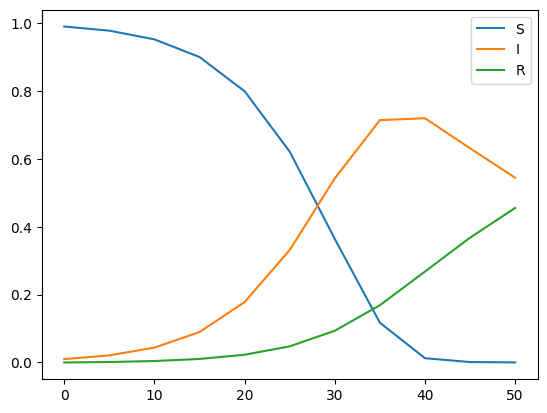

In [11]:

# Use dreal instead of z3
from pysmt.logics import QF_NRA

from funman_dreal.solver import ensure_dreal_in_pysmt

ensure_dreal_in_pysmt()

opts = {
        "dreal_precision": 1e-3,
        "dreal_log_level": "none",
        "dreal_mcts": True,
    }

max_time = 50
step_size = 5

values= None
with Solver(name="dreal",
            logic=QF_NRA,
            solver_options=opts
            ) as solver:
    values = run_solver(solver, encode(max_time=max_time, step_size=step_size, noise=noise, use_compartmental=True))
    pass
    
if values:
    ax, results = plot_results(values,  max_time, step_size)
    f_pop = results.loc[float(max_time)][["S", "I", "R"]].sum()
    print(f"Population at end: {f_pop}")
    s = list(results.S.values)
    print([s[i]-s[i-1] for i in range(1, len(s))])